In [ ]:
!pip install kaggle

In [ ]:
!mkdir kaggle

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [04:24<00:00, 22.6MB/s]
100% 5.20G/5.20G [04:24<00:00, 21.1MB/s]


In [ ]:
!cd /content/kaggle

In [ ]:
!unzip /content/skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [ ]:
import pandas as pd
import os
import tensorflow as tf
import keras.preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import glob
from tqdm import tqdm

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D


In [ ]:
import os

# Define the source folders
source_folder1 = '/content/HAM10000_images_part_1'
source_folder2 = '/content/HAM10000_images_part_2'

# Define the destination folder
destination_folder = '/content/HAM10000_merged'

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Loop through files in both source folders
for source_folder in [source_folder1, source_folder2]:
  for filename in os.listdir(source_folder):
    # Construct the source file path
    source_path = os.path.join(source_folder, filename)

    # Construct the destination file path (avoid overwriting)
    destination_path = os.path.join(destination_folder, filename)
    i = 1
    while os.path.exists(destination_path):  # Check if file already exists
      new_filename, extension = os.path.splitext(filename)
      destination_path = os.path.join(destination_folder, f"{new_filename}_{i}{extension}")
      i += 1

    # Move the file to the destination folder
    os.rename(source_path, destination_path)

print("Files merged successfully!")

Files merged successfully!


In [ ]:
lesion_type_dict = {
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'

}

In [ ]:
data = pd.read_csv('/content/HAM10000_metadata.csv', sep=',')
data = data.sort_values(by='image_id')
data

,lesion_id,image_id,dx,dx_type,age,sex,localization
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest
...,...,...,...,...,...,...,...
1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity
1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk
7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk


In [ ]:


# Now, 'data' has the DataFrame with sorted image IDs
# data  # Print the first few rows to verify sorting
data['path'] = "/content/HAM10000_merged/"+data['image_id'] +".jpg"
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['dx_class_index'] = pd.Categorical(data['dx']).codes
data



,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,dx_class_index
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,/content/HAM10000_merged/ISIC_0024306.jpg,Melanocytic Nevi,5
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,/content/HAM10000_merged/ISIC_0024307.jpg,Melanocytic Nevi,5
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,/content/HAM10000_merged/ISIC_0024308.jpg,Melanocytic Nevi,5
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,/content/HAM10000_merged/ISIC_0024309.jpg,Melanocytic Nevi,5
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest,/content/HAM10000_merged/ISIC_0024310.jpg,Melanoma,4
...,...,...,...,...,...,...,...,...,...,...
1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity,/content/HAM10000_merged/ISIC_0034316.jpg,Melanoma,4
1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity,/content/HAM10000_merged/ISIC_0034317.jpg,Melanoma,4
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk,/content/HAM10000_merged/ISIC_0034318.jpg,Benign keratosis-like lesions,2
7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk,/content/HAM10000_merged/ISIC_0034319.jpg,Melanocytic Nevi,5


In [ ]:
perwakilan_per_kelas = data.groupby('dx').first().reset_index()

# Menampilkan perwakilan dari masing-masing kelas
# print(perwakilan_per_kelas)

# Menampilkan perbandingan antara 'dx' dan 'dx_class_index'
print("\nPerbandingan 'dx' dan 'dx_class_index' (perwakilan):")
print(perwakilan_per_kelas[['dx','cell_type', 'dx_class_index']])


Perbandingan 'dx' dan 'dx_class_index' (perwakilan):
      dx                       cell_type  dx_class_index
0  akiec               Actinic keratoses               0
1    bcc            Basal cell carcinoma               1
2    bkl  Benign keratosis-like lesions                2
3     df                  Dermatofibroma               3
4    mel                        Melanoma               4
5     nv                Melanocytic Nevi               5
6   vasc                Vascular lesions               6


In [ ]:
jumlah_kelas = data['dx'].nunique()
print("Jumlah kelas:", jumlah_kelas)

jumlah_data_per_kelas = data['dx'].value_counts()
print("Jumlah data per kelas:")
jumlah_data_per_kelas


Jumlah kelas: 7
Jumlah data per kelas:


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Jumlah Kelas: 4
Jumlah data per kelas:


dx_type
histo        5340
follow_up    3704
consensus     902
confocal       69
Name: count, dtype: int64

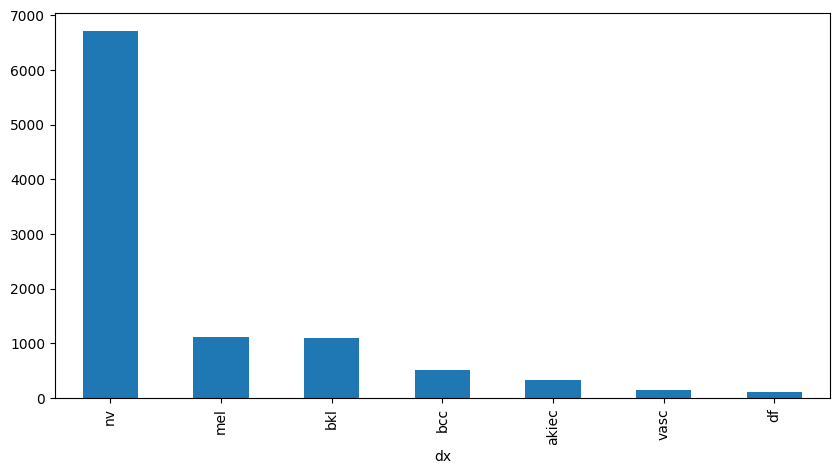

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
data['dx'].value_counts().plot(kind='bar', ax=ax1)

jumlah_kelas_type = data['dx_type'].nunique()
print('Jumlah Kelas:', jumlah_kelas_type)

jumlah_data_per_kelas_type = data['dx_type'].value_counts()
print("Jumlah data per kelas:")
jumlah_data_per_kelas_type

In [ ]:
import pandas as pd

# Jumlah duplikasi untuk setiap kelas
duplication_amount = {
    0: 17,
    1: 11,
    2: 4,
    3: 52,
    4: 4,
    5: 1,  # Tambahkan kelas 5 dengan jumlah duplikasi 0
    6: 45
}

# Pisahkan fitur (path gambar) dan label (indeks kelas)
x = data.drop(columns=['dx_class_index'])
y = data['dx_class_index']

# Inisialisasi list untuk menyimpan hasil duplikasi
duplication_results = []

# Lakukan duplikasi manual
for class_index, amount in duplication_amount.items():
    # Filter data berdasarkan indeks kelas
    class_data = data[data['dx_class_index'] == class_index]
    # Duplikasi data sebanyak yang diminta
    for _ in range(amount):
        duplication_results.append(class_data)

# Gabungkan hasil duplikasi menjadi satu DataFrame
resampled_data = pd.concat(duplication_results, ignore_index=True)

# Sekarang, resampled_data berisi data yang telah di-duplikasi
# resampled_data


In [ ]:
resampled_data

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,dx_class_index
0,HAM_0002954,ISIC_0024329,akiec,histo,75.0,female,lower extremity,/content/HAM10000_merged/ISIC_0024329.jpg,Actinic keratoses,0
1,HAM_0005389,ISIC_0024372,akiec,histo,70.0,male,lower extremity,/content/HAM10000_merged/ISIC_0024372.jpg,Actinic keratoses,0
2,HAM_0003380,ISIC_0024418,akiec,histo,75.0,female,lower extremity,/content/HAM10000_merged/ISIC_0024418.jpg,Actinic keratoses,0
3,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,/content/HAM10000_merged/ISIC_0024450.jpg,Actinic keratoses,0
4,HAM_0004568,ISIC_0024463,akiec,histo,50.0,male,upper extremity,/content/HAM10000_merged/ISIC_0024463.jpg,Actinic keratoses,0
...,...,...,...,...,...,...,...,...,...,...
39131,HAM_0003480,ISIC_0033844,vasc,consensus,70.0,female,lower extremity,/content/HAM10000_merged/ISIC_0033844.jpg,Vascular lesions,6
39132,HAM_0000940,ISIC_0033969,vasc,histo,35.0,female,lower extremity,/content/HAM10000_merged/ISIC_0033969.jpg,Vascular lesions,6
39133,HAM_0006852,ISIC_0033991,vasc,consensus,45.0,female,abdomen,/content/HAM10000_merged/ISIC_0033991.jpg,Vascular lesions,6
39134,HAM_0001852,ISIC_0034196,vasc,histo,80.0,male,lower extremity,/content/HAM10000_merged/ISIC_0034196.jpg,Vascular lesions,6


In [ ]:
jumlah_kelas = resampled_data['dx'].nunique()
print("Jumlah kelas setelah upsampling:", jumlah_kelas)

jumlah_data_per_kelas = resampled_data['dx'].value_counts()
print("Jumlah data per kelas setelah upsampling:")
jumlah_data_per_kelas


Jumlah kelas setelah upsampling: 7
Jumlah data per kelas setelah upsampling:


dx
nv       6705
vasc     6390
df       5980
bcc      5654
akiec    5559
mel      4452
bkl      4396
Name: count, dtype: int64

Jumlah Kelas: 4
Jumlah data per kelas:


dx_type
histo        27102
consensus     8054
follow_up     3704
confocal       276
Name: count, dtype: int64

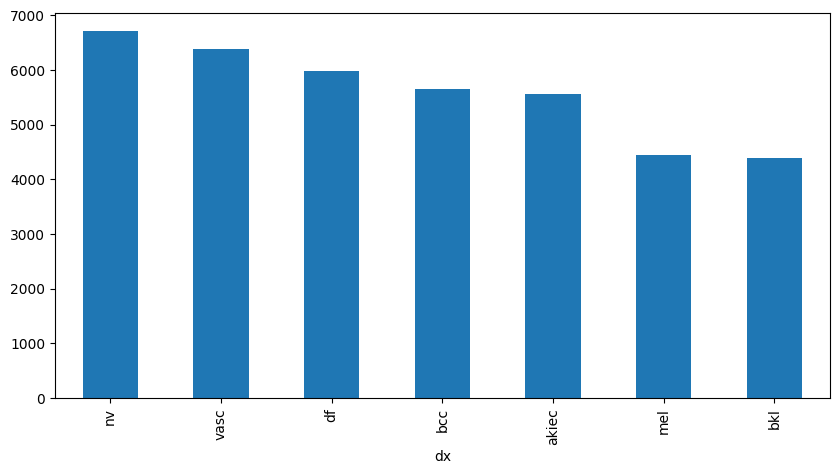

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
resampled_data['dx'].value_counts().plot(kind='bar', ax=ax1)

jumlah_kelas_type = resampled_data['dx_type'].nunique()
print('Jumlah Kelas:', jumlah_kelas_type)

jumlah_data_per_kelas_type = resampled_data['dx_type'].value_counts()
print("Jumlah data per kelas:")
jumlah_data_per_kelas_type

In [ ]:
y = resampled_data['dx_class_index']
x = resampled_data.drop(columns = ['dx_class_index'])

In [ ]:
IMAGE_SIZE = 71
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  return img
train_img = []
for img_name in tqdm(resampled_data['path'].values):
  train_img.append(read_img(img_name))

100%|██████████| 39136/39136 [05:13<00:00, 124.77it/s]


In [ ]:
X = np.array(train_img,np.float32)/255
print(X.shape)

(39136, 71, 71, 3)


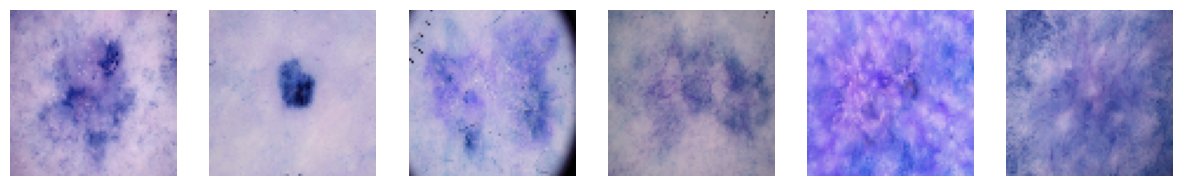

In [ ]:
#Visulaizing the normalized images
plt.figure(figsize=(15,12))
for i in range(1,7,1):
    plt.subplot(1,6,i)
    plt.imshow(X[i])
    plt.axis('off')
plt.show()

In [ ]:
y = np.array(resampled_data['dx_class_index'])


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.10,random_state=28,stratify=y)
x_train,x_val,y_train,y_val =   train_test_split(x_train,y_train,test_size=0.10,random_state=28,stratify=y_train)

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras.applications import Xception,VGG16,ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.models import Sequential, Model

In [ ]:
# One-Hot Encoding values
y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val , num_classes=7)
y_test =to_categorical(y_test , num_classes=7)

In [ ]:
# Defining base model using Xception module from Keras
training_shape = (71,71,3)
base_model = Xception(include_top=False,weights='imagenet',input_shape = training_shape)
for layer in base_model.layers:
    layer.trainable = True                         # Training all layers from scratch

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
#Adding layers at end
n_classes = 7
model = base_model.output
model = Flatten()(model)
model = Dense(128)(model)
model = Dropout(0.5)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
output = Dense(n_classes, activation='softmax')(model)
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compiling the model
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 71, 71, 3)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 35, 35, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 35, 35, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 35, 35, 32)           0         ['block1_conv1_bn[0][0]'] 

In [ ]:
# Defining callback Methods
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

In [ ]:
# Fitting the model
history = model.fit(x_train,
                    y_train,
                    epochs=n_epoch,
                    callbacks=[reduce_lr,early_stop],
                    validation_data=(x_val,y_val)
                   )

Epoch 1/10
991/991 [==============================] - 72s 41ms/step - loss: 0.6497 - accuracy: 0.7719 - val_loss: 0.4260 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 2/10
991/991 [==============================] - 37s 38ms/step - loss: 0.2858 - accuracy: 0.9038 - val_loss: 0.2420 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 3/10
991/991 [==============================] - 38s 38ms/step - loss: 0.1834 - accuracy: 0.9379 - val_loss: 0.1717 - val_accuracy: 0.9424 - lr: 0.0010
Epoch 4/10
991/991 [==============================] - 37s 38ms/step - loss: 0.1219 - accuracy: 0.9603 - val_loss: 0.1416 - val_accuracy: 0.9481 - lr: 0.0010
Epoch 5/10
991/991 [==============================] - 37s 38ms/step - loss: 0.1023 - accuracy: 0.9683 - val_loss: 0.0980 - val_accuracy: 0.9637 - lr: 0.0010
Epoch 6/10
991/991 [==============================] - 37s 38ms/step - loss: 0.0867 - accuracy: 0.9732 - val_loss: 0.1307 - val_accuracy: 0.9682 - lr: 0.0010
Epoch 7/10
991/991 [==============================] - 37s 

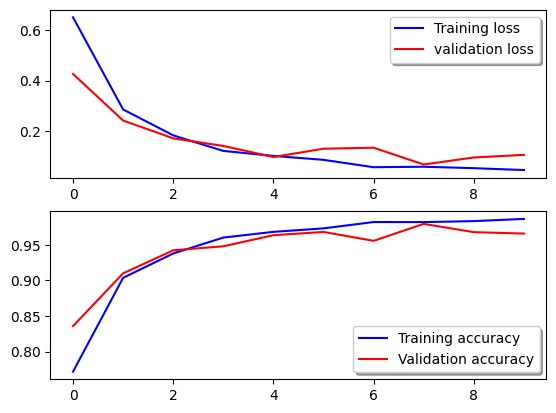

In [ ]:
# Plotting the results on Graph
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
train_loss = history.history['loss'][-1] * 100
val_loss = history.history['val_loss'][-1] * 100
train_acc = history.history['accuracy'][-1] * 100
val_acc = history.history['val_accuracy'][-1] * 100

# Print results
print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Validation Accuracy: {val_acc:.2f}%")
print(f"Training Loss: {train_loss:.2f}%")
print(f"Validation Loss: {val_loss:.2f}%")


Training Accuracy: 98.65%
Validation Accuracy: 96.59%
Training Loss: 4.64%
Validation Loss: 10.64%


In [ ]:


# Get the train accuracy
train_loss, train_accuracy = model.evaluate(x_train, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Get the val accuracy
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
scores = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

991/991 [==============================] - 9s 9ms/step - loss: 0.0433 - accuracy: 0.9867
Train Loss: 0.043277110904455185
Train Accuracy: 0.9866873025894165
111/111 [==============================] - 1s 9ms/step - loss: 0.1064 - accuracy: 0.9659
Val Loss: 0.10635191202163696
Val Accuracy: 0.9659380912780762
123/123 [==============================] - 1s 9ms/step - loss: 0.1195 - accuracy: 0.9642
Test Loss: 0.1194625273346901
Test Accuracy: 0.9642309546470642


123/123 [==============================] - 2s 8ms/step
Classification Report:
              precision    recall  f1-score   support

       akiec       1.00      1.00      1.00       556
         bcc       1.00      0.95      0.97       565
         bkl       0.92      0.98      0.95       440
          df       1.00      1.00      1.00       598
         mel       0.86      0.98      0.92       445
          nv       0.97      0.86      0.91       671
        vasc       0.99      1.00      0.99       639

    accuracy                           0.96      3914
   macro avg       0.96      0.97      0.96      3914
weighted avg       0.97      0.96      0.96      3914

Confusion Matrix:


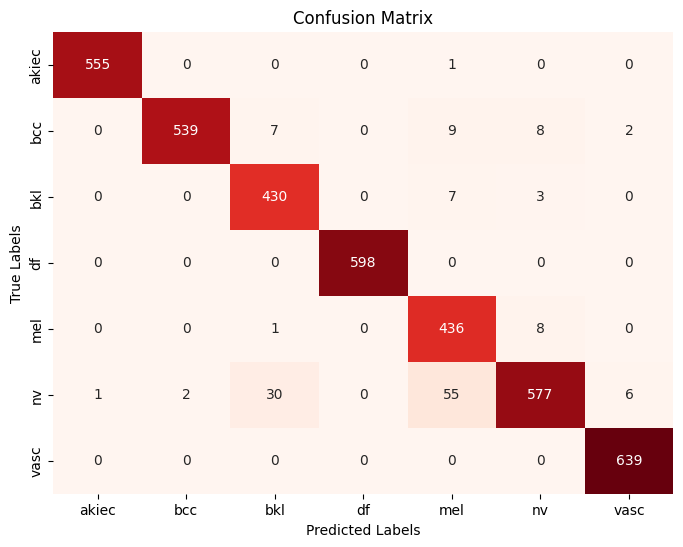

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Prediksi pada data uji
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
test_pred = model.predict(x_test)
test_pred = np.argmax(test_pred, axis=1)
test_label = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(test_label, test_pred, target_names=targetnames))

# Confusion Matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(test_label, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=targetnames, yticklabels=targetnames, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
